In [1]:
import gc
import os
import nltk
import tqdm
import numpy as np
import pandas as pd
import string
import keras
import keras.backend as K
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eshanka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

Setting up parameter globals

In [3]:
gru_len = 256
Routings = 5
Num_capsule = 2
Dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

batch_size = 128
recurrent_units = 64
dropout_rate = 0.3 
dense_size = 20
sentences_length = 50
fold_count = 10

Non-linear activation fucntion for capsule layer

In [4]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

Generating the capsule network algorithm with slight tweaks to optimize with the dataset


In [14]:
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True, activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel', shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule), initializer='glorot_uniform', trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel', shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule), initializer='glorot_uniform', trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1),)  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(b, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

Tokenization

In [6]:
def rmv_acc(string_1):

    string_1 = string_1.replace("ç", "c")
    string_1 = string_1.replace("Ç", "C")
    string_1 = string_1.replace("à", "a")
    string_1 = string_1.replace("Ä", "A")
    string_1 = string_1.replace("ä", "a")
    string_1 = string_1.replace("À", "A")
    string_1 = string_1.replace("Â", "A")
    string_1 = string_1.replace("â", "a")
    string_1 = string_1.replace("é", "e")
    string_1 = string_1.replace("è", "e")
    string_1 = string_1.replace("É", "E")
    string_1 = string_1.replace("È", "E")
    string_1 = string_1.replace("Ë", "E")
    string_1 = string_1.replace("ë", "e")
    string_1 = string_1.replace("Ê", "E")
    string_1 = string_1.replace("ê", "e")
    string_1 = string_1.replace("û", "u")
    string_1 = string_1.replace("Û", "U")
    string_1 = string_1.replace("ü", "u")
    string_1 = string_1.replace("Ü", "U")
    string_1 = string_1.replace("ï", "i")
    string_1 = string_1.replace("Ï", "I")
    string_1 = string_1.replace("î", "i")
    string_1 = string_1.replace("Î", "I")
    string_1 = string_1.replace("Ô", "O")
    string_1 = string_1.replace("ô", "o")
    string_1 = string_1.replace("Ö", "O")
    string_1 = string_1.replace("ö", "o")
    string_1 = string_1.replace("Ù", "U")
    string_1 = string_1.replace("ù", "u")
    string_1 = string_1.replace("ÿ", "y")
    string_1 = string_1.replace("æ", "ae")
    string_1 = string_1.replace("_", " ")
    string_1 = string_1.replace("\n", "")

    return string_1

Reading dataset and Tokenizing the host urls

In [7]:
dframe = pd.read_csv('Datasets/dga_data.csv', sep = ',')
dframe = pd.DataFrame(dframe)
df = dframe[["host","isDGA"]]
domains = df['host'].apply(lambda x: rmv_acc(x))
labels = df['isDGA']

In [8]:
all_letters = set(' '.join([str(i) for i in domains]))
all_letters.add("END")
len_letters = len(all_letters)
char_map = {v: k for k, v in enumerate(all_letters)}

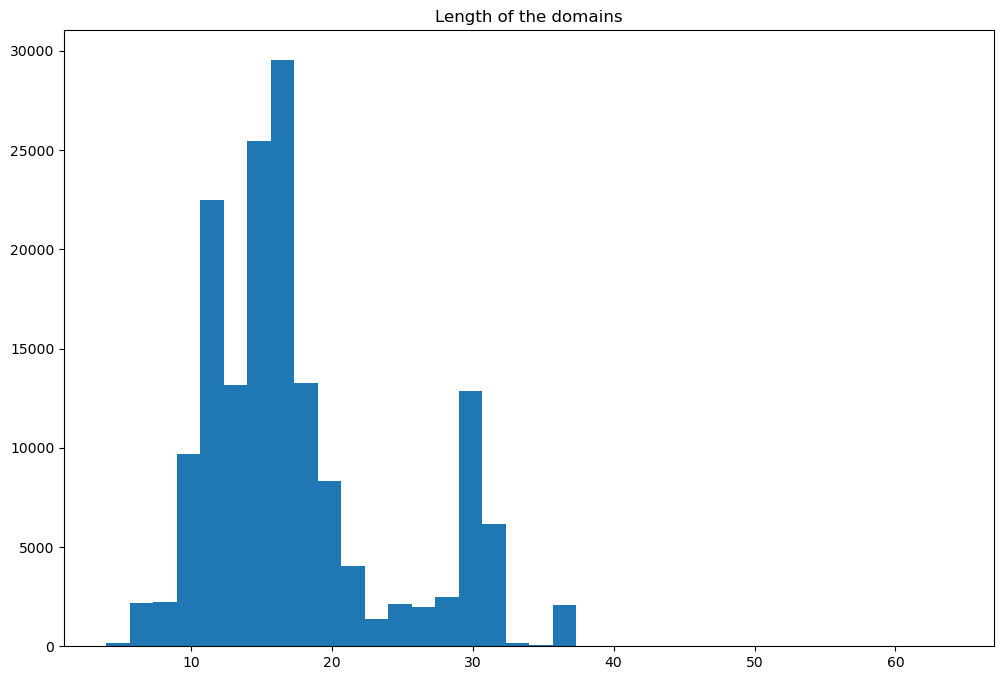

In [9]:
plt.figure(figsize=(12,8))
plt.hist([len(a) for a in domains], bins=36)
plt.title("Length of the domains")
plt.show()

Embedding the dataset in a character level

In [10]:
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    tmp = np.zeros(len_letters)
    tmp[i] = 1
    return list(tmp)

# Truncate names and create the matrix
def prepare_X(X):
    new_list = []
    trunc_train_name = [str(i)[0:sentences_length] for i in X]

    for i in trunc_train_name:
        tmp = [set_flag(char_map[j]) for j in str(i)]
        for k in range(0,sentences_length - len(str(i))):
            tmp.append(set_flag(char_map["END"]))
        new_list.append(tmp)

    return new_list


X = prepare_X(domains.values)

def prepare_y(y):
    new_list = []
    for i in y:
        if i == 'dga':
            new_list.append([1,0])
        else:
            new_list.append([0,1])

    return new_list

y = prepare_y(labels)



Spliting training and testing values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Casting train and test lists into numpy arrays of type float

In [12]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


In [13]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((107200, 50, 40), (107200, 2), (52800, 50, 40), (52800, 2))

DL model

In [15]:
def get_model(sequence_length, len_letters, dropout_rate, dense_size):
    inputs = Input(shape=(sequence_length,len_letters,))
    bi = Bidirectional(GRU(gru_len, activation='relu', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True),backward_layer=GRU(gru_len, return_sequences=True, go_backwards=True))(inputs)
    capsule = Capsule(num_capsule=Num_capsule, dim_capsule=Dim_capsule, routings=Routings, share_weights=True)(bi)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_rate)(capsule)
    capsule = Dense(dense_size, activation='relu')(capsule)
    capsule = Flatten()(capsule)
    output = Dense(2, activity_regularizer=l2(0.002), activation='sigmoid')(capsule)
    model = Model(inputs=inputs, outputs=output, name="CapsDGA")
    return model

In [27]:
def get_model(sequence_length, len_letters, dropout_rate, dense_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(512, return_sequences=True), backward_layer=LSTM(512, return_sequences=True, go_backwards=True), input_shape=(sentences_length,len_letters)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dropout(0.2))
    model.add(Dense(2, activity_regularizer=l2(0.002)))
    model.add(Activation('softmax'))
    return model

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Monitoring and model saving

In [16]:
#callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model_9.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [ ]:
# batch_size = 256
# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=35, verbose=1, validation_data =(X_test, y_test), callbacks=[mc, reduce_lr_acc])

Getting the model object with the layers loaded in and getting the summary on it

In [17]:
dgaModel = get_model(sentences_length, len_letters, dropout_rate, dense_size)
dgaModel.summary()

ValueError: in user code:

    <ipython-input-14-21346bf09e54>:37 call  *
        b = K.permute_dimensions(b, (0, 2, 1),)  # shape = [None, input_num_capsule, num_capsule]
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\keras\backend.py:2943 permute_dimensions
        return array_ops.transpose(x, perm=pattern)
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\ops\array_ops.py:2188 transpose
        return transpose_fn(a, perm, name=name)
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:11533 transpose
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\Eshanka\.conda\envs\IITMLsesh\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension must be 4 but is 3 for '{{node capsule/transpose_6}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](capsule/Reshape_4, capsule/transpose_6/perm)' with input shapes: [?,2,2,?], [3].


To get an idea on the models inputs and outputs

In [50]:
[print(i.shape, i.dtype) for i in dgaModel.inputs]
[print(o.shape, o.dtype) for o in dgaModel.outputs]
[print(l.name, l.input_shape, l.dtype) for l in dgaModel.layers]

(None, 50, 40) <dtype: 'float32'>
(None, 2) <dtype: 'float32'>
input_11 [(None, 50, 40)] float32
bidirectional_11 (None, 50, 40) float32
flatten_9 (None, 50, 512) float32
dropout_7 (None, 25600) float32
dense_9 (None, 25600) float32
flatten_10 (None, 20) float32
dropout_8 (None, 20) float32
dense_10 (None, 20) float32


[None, None, None, None, None, None, None, None]

Compiling and fitting model

In [ ]:
dgaModel.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print("Starting to train models...")
dgaModel.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=20, verbose = 1, callbacks=[callback, mc, reduce_lr_acc])